# Using Astrobject to read an Image and extract sources

Required ingredients:
Image with a wcs solution and a target. 

The examples data "image" and "target" are provided in the "notebooks/data" directory.

**Remark**: If the Image comes from a known instrument (sdss, hst, ptf) you should use the 'Instrument' Class instead of the 'Image' one. 'Intruments' inherit from 'Image' and have additional functionalities. Just change "image" to "instrument"


In [1]:
## plot within the notebook
%matplotlib notebook
import warnings
## No annoying warnings
warnings.filterwarnings('ignore')
# - Astrobject Modules
from astrobject.utils.tools import load_pkl
from astrobject import get_target
from astrobject import get_image, get_instrument

## Step one: loading the image and access the data

<IPython.core.display.Javascript object>


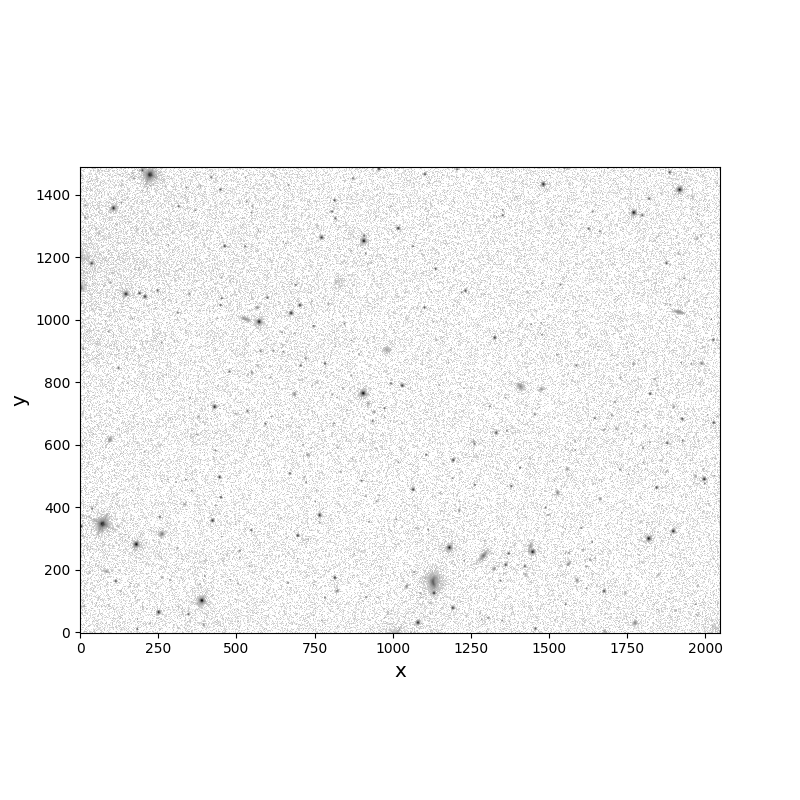

In [2]:
# Load an image object by giving the fits file.
sdssg = get_instrument("data/sdss_PTF10qjq_g.fits")
# - Let's see how it looks like
pl = sdssg.show(logscale=True)

In [3]:
sdssg.download_catalogue("panstarrs")

<IPython.core.display.Javascript object>


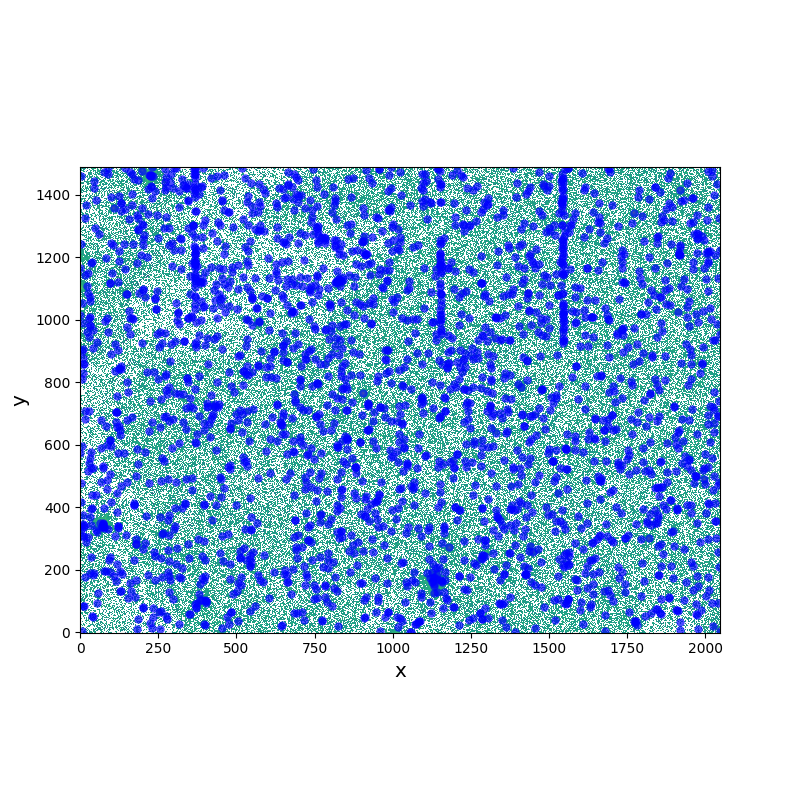

In [4]:
_ = sdssg.show(cmap="viridis", show_catalogue=True)

#### The show() method returns a dictionnary containing the basic plot information:
* figure: a matplotlib.figure
* ax: the axis where the plot has been made
* imshow/plot/hist/...: the return of the plotting function used, here "imshow"
* prop: information of the properties of the plot (kwargs)
* ... (depending of what you shown)

**_Tip_** use string values for "vmin" and "vmax" imshow argument to use them as percentile values. e.g. vmin="3" means that the vmin value will be percentile(_plotted_value_,3).

In [3]:
print pl

{'ax': <matplotlib.axes._axes.Axes object at 0x1184105d0>, 'imshow': <matplotlib.image.AxesImage object at 0x101bff810>, 'target_plot': None, 'figure': <matplotlib.figure.Figure object at 0x10dcf3810>, 'prop': {'origin': 'lower', 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x104fea7d0>, 'interpolation': 'nearest'}}


### Construction of the image data.

The "data" is a derived parameter. It is based on "rawdata", which is the information recorded in the fits file to which is subtracted a "background". This "background" could you manually set (using set_background()), but as a default it uses the sep library. In the code (see get_sep_background()) sep is ran once to get the background and the detected sources and a second time to get the background once the sources have been masked. 

You can see the "rawdata" and the "background" using the show() method as follow:

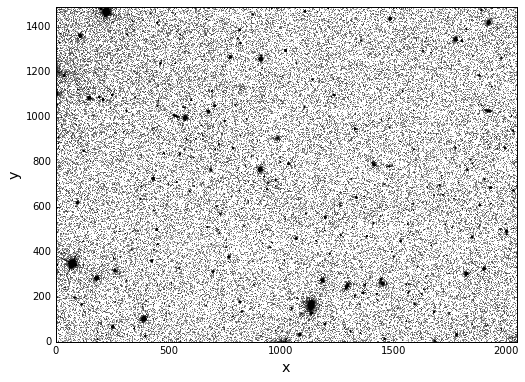

In [4]:
# The Rawdata (shown in logscale, which is the default of the show() method), using vmin and vmax as percentile values
pl = sdssg.show("rawdata",vmax="99",vmin="5")

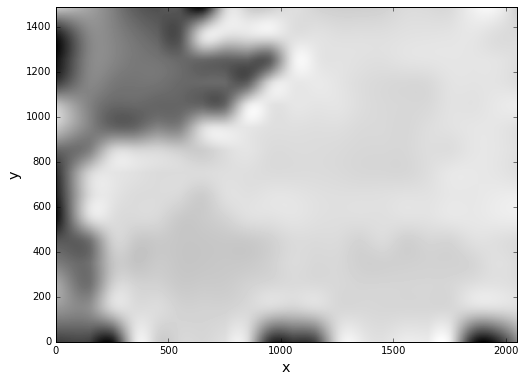

In [5]:
# The background ; see the background mask array using backgroundmask
pl = sdssg.show("background", logscale=False)

#### The show_background() check method:
A methods to visualize the background and the exact data used to estimated the background is implemented under the 'show_background(')method. Except for 'toshow' and 'logscale' (that are here fixed), the argument are these of the 'show()' method used internally.

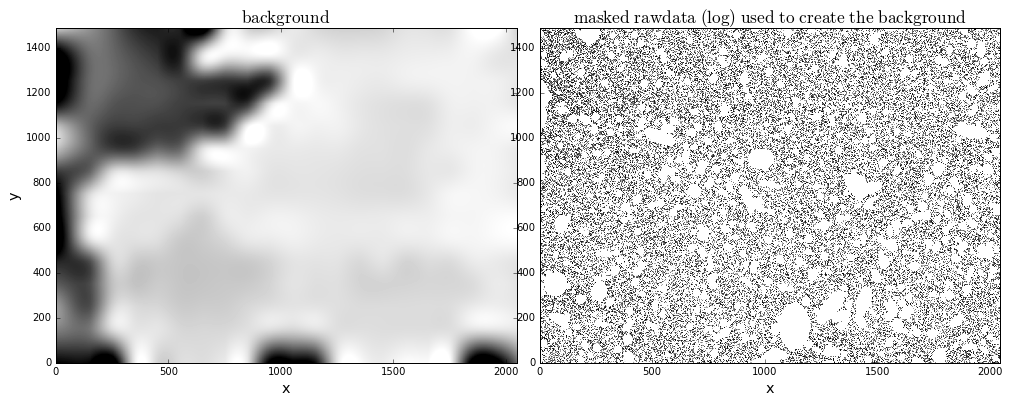

In [6]:
pl = sdssg.show_background(vmin="1",vmax="99")

## Step two: Associating a target to an image

An astrotarget is an object having basic information about a source (whatever that is). 
It has: 
* coordinates (Ra, Dec)
* a name (name)
* a redshift (zcmb)
* a type (type_, like Ia, galaxy...)

Additional information could also be provided:
* the milky way extinction (forced_mwebmv, if this is not provided, the code will fetch it based on Schelgel map)
* a cosmology (cosmo, this must be an astropy.cosmo; Planck13 is currently used as default)

**Remark**: none of the aforementioned information is requested, you can create an empty or partially filled object. 
Several other parameter will however be accessible once the object is set:
* distances (in meter or mpc) if zcmb and a cosmo are provided
* mwebmv (with Ra and Dec)

**Remark**: you can not change the distance, but changing zcmb will do so.

In [7]:
# -------------------------
# - Build the astrotarget
# -------------------------
# Basic data
dicosn = load_pkl("data/PTF10qjq_sninfo.pkl")
print dicosn

{'object': u'PTF10qjq', 'Ra': 256.801708333, 'zcmb': 0.028107, 'Dec': 35.5098277778, 'type': u'Ia', 'MWebmv': 0.0279, 'IUACname': None}


In [8]:
# Create the astrotarget
sn = get_target(name=dicosn["object"], zcmb=dicosn["zcmb"],
                 ra=dicosn["Ra"],dec=dicosn["Dec"],
                 type_=dicosn["type"],forced_mwebmv=dicosn["MWebmv"])

Planck 2015 cosmology used by default


In [9]:
print sn.zcmb, sn.ra, sn.dec, sn.distmeter

0.028107 256.801708333 35.5098277778 3.92035026287e+24


### You can now connect the target with the image

In [10]:
# let's add a target
sdssg.set_target(sn)

#### The image have wcs tools that enable to go from Ra,Dec (coords) to pixels indexes
The methodes are pixel_to_coords(x,y) and coords_to_pixels(ra,dec)

In [11]:
# for the 1000,800 point:
print "pixel [1000,800] the corresponding Ra,Dec are", sdssg.pixel_to_coords(1000,800)
# for the target
print "pixel set target the corresponding pixels coords are",sdssg.coords_to_pixel(sn.ra,sn.dec)

pixel [1000,800] the corresponding Ra,Dec are [ 256.82751281   35.44162575]
pixel set target the corresponding pixels coords are [ 1129.34872146   164.30083776]


#### Remark that now, when you plot, a white square shows the target location in the image

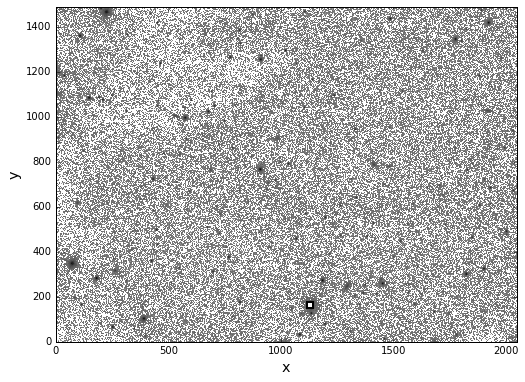

In [12]:
pl = sdssg.show()

#### You can also "zoomon":
* "target" (that will be converted in the target's pixel coords)
* any pixel coords

This will center the image on the requested coordinates with a image window set by "zoompxl" (default 200pxl)

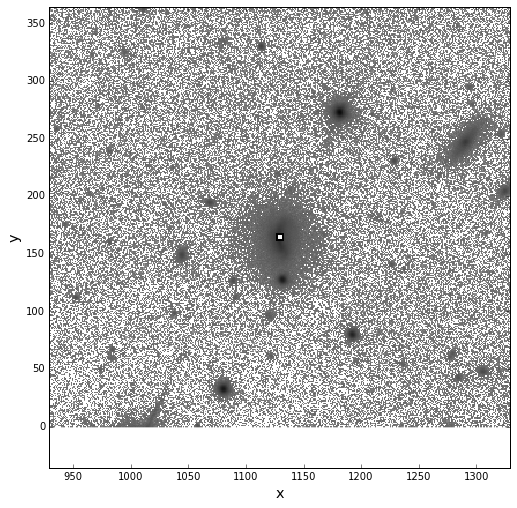

In [13]:
pl = sdssg.show(zoomon="target")

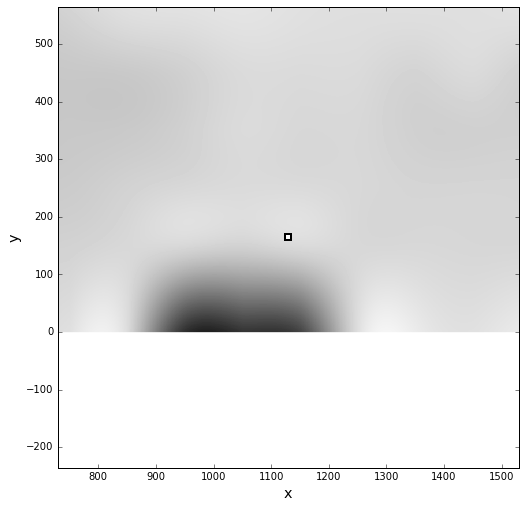

In [14]:
# Which also work with the background, rawdata etc.
pl = sdssg.show(toshow="background", zoomon='target', zoom=400, logscale=False)

## Step Three: The source extraction

Thanks to the sep package, (a python/c based API of Sextractor) it is really conviniant to extract sources from the image.

The module sep_extract() runs the extraction on the current image and load the results in the 'sepobjects' object.


In [15]:
sdssg.sep_extract()

visualization of the extracted sources with the show() methods: set show_sepobjects=True.

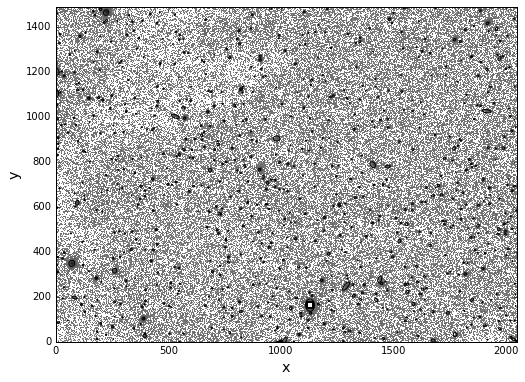

In [16]:
pl = sdssg.show(show_sepobjects=True)

**Remark** several sources have been detected that potentially are image artefacts. Thanks to catalogue matching this issue is solved since sepobjects will know if a source is associated to a catalogue object and which object that is. See the corresponding example

**Information** The image catalogue (if any) and wcs solution (if any) are passed to the sepobjects.

### The SexObjects, play with extracted sources.

#### The sep sources information are recorded in 'sepobjects' (SexObject instance)
**_Tip_** you can test if an 'Image' has a sepobjects loaded using the has_sepobjects() methods (returns True if so)

#### How to use the sepobjects

* The ellipses information are recorded in the astropy table 'data' 

In [17]:
sdssg.sepobjects.data

id,flux,var,lbda,mjd,bandname,zp,zpsys
str27,float64,float64,object,object,object,object,str2
"1.42185218,1015.98303701",0.249633550644,nan,None,None,None,None,ab
"1.96466585,1243.51727405",0.678813159466,nan,None,None,None,None,ab
"10.57226934,879.31521728",2.14593172073,nan,None,None,None,None,ab
"1001.73871895,0.66930888",1.71955299377,nan,None,None,None,None,ab
"1004.96337203,1056.04384801",0.426364094019,nan,None,None,None,None,ab
"1005.58311142,1480.18991958",0.218035116792,nan,None,None,None,None,ab
"101.87801924,1149.30506836",0.624792873859,nan,None,None,None,None,ab
"1011.02104443,362.52429257",4.4208817482,nan,None,None,None,None,ab
"1013.44609754,676.60724531",0.480775564909,nan,None,None,None,None,ab


* you can access each column using sepobjects.data[key] or sepobjects.get(key). Additional key are aviable in throught the get methods that combine dat information: "elongation","ellipticity" and "angsep" (the distance between the sep extracted source and the associated catalogue object; this won't be accessible if no catalogue have been loaded)

## Additional tools are available when combined with a catalogue. 
### See the Instrument and Catalogue notebook.

In [18]:
sdssg.download_catalogue("sdss")

{'ax': <matplotlib.axes._axes.Axes at 0x1145b6b10>,
 'figure': <matplotlib.figure.Figure at 0x1145b83d0>,
 'imshow': <matplotlib.image.AxesImage at 0x114961ad0>,
 'prop': {'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x104fea7d0>,
  'interpolation': 'nearest',
  'origin': 'lower'},
 'target_plot': [<matplotlib.lines.Line2D at 0x114961d10>]}

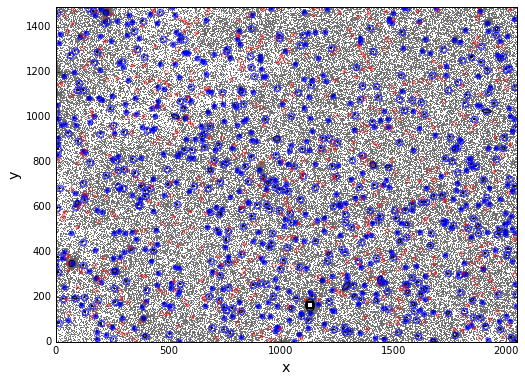

In [19]:
sdssg.show( show_catalogue=True, show_sepobjects=True)